In [6]:
import numpy as np
import matplotlib.pyplot as plt

from common_pyfuncs import *

plt.rcParams.update({'font.size': 14})

sol_filename = "sundials2_sol.csv"
#SDsol_filename = "sundials2_SDsol.csv"
#SDsol_filename = "collsonly32768_SDsol.csv"
SDsol_filename = "collsonly8192_SDsol.csv"

### read in constants from .hpp files
CONSTS, notfloats = read_cpp_into_floats("./constants.hpp")
INITS, notfloats2 = read_cpp_into_floats("./init.hpp") 
MCONSTS = {}
MCONSTS["RGAS_DRY"]   = CONSTS["RGAS_UNIV"]/CONSTS["MR_DRY"]
MCONSTS["RGAS_V"]     = CONSTS["RGAS_UNIV"]/CONSTS["MR_WATER"]
MCONSTS["RHO0"]       = CONSTS["P0"]/(MCONSTS["RGAS_DRY"]*CONSTS["TEMP0"]) 
MCONSTS["CP0"]        = CONSTS["CP_DRY"]                
MCONSTS["MR0"]        = CONSTS["MR_DRY"]  
MCONSTS["Mr_ratio"]     = CONSTS["MR_WATER"]/CONSTS["MR_DRY"]
INITS["nsupers"]      = int(INITS["nsupers"])

print("---- Additional Constants Derived -----")
for c in MCONSTS:
  print(c, "=", MCONSTS[c])
nsupers    = int(INITS["nsupers"])                  
VOL = INITS["iVOL"]                                # parcel volume [m]                    
print("---------------------------------------------")


---- Constants read from  ./constants.hpp -----
G = 9.80665
RGAS_UNIV = 8.314462618
MR_WATER = 0.01801528
MR_DRY = 0.0289647
LATENT_V = 2437300.0
CP_DRY = 1004.9
CP_V = 1864.0
C_L = 4180.0
RHO_DRY = 1.177
RHO_L = 1000.0
e = 1000000.0
RHO_SOL = 2200.0
MR_SOL = 0.058443
IONIC = 2.0
W0 = 0.5
TIME0 = 4000.0
P0 = 100000.0
TEMP0 = 273.15
R0 = 1e-06
---------------------------------------------
---- Not floats read from  ./constants.hpp -----
RGAS_DRY = RGAS_UNIV/MR_DRY
RGAS_V = RGAS_UNIV/MR_WATER
DYNVISC = 18.45*1e-6
LATENT_RGAS_V = LATENT_V/RGAS_V
RHO0 = P0/(DC::RGAS_DRY*TEMP0)
CP0 = DC::CP_DRY
MR0 = DC::MR_DRY
F0 = TIME0/(RHO0*R0*R0)
Mr_ratio = DC::MR_WATER/DC::MR_DRY
Cp_dry = DC::CP_DRY / CP0
Cp_v = DC::CP_V / CP0
C_l = DC::C_L / CP0
Latent_v = DC::LATENT_V/(TEMP0*CP0)
Rgas_dry = DC::RGAS_DRY/CP0
Rho_dry = DC::RHO_DRY/RHO0
Rho_l = DC::RHO_L/RHO0
Rho_sol = DC::RHO_SOL/RHO0
Mr_sol = DC::MR_SOL/MR0
IONIC = DC::IONIC
---------------------------------------------
---- Constants read from  ./in

In [7]:
### Helper Functions 
def saturation_pressure(T):
  ''' Calculate the equilibrium vapor pressure 
  of water over liquid water ie. the
  saturation pressure (psat [Pa]). Equation taken from
  typhon.physics.thermodynamics.e_eq_water_mk.'''
  
  if np.any(T <= 0):
      err = 'T must be larger than 0K.'
      raise ValueError(err)

  lnpsat = (54.842763                    # ln(psat) [Pa]
        - 6763.22 / T
        - 4.21 * np.log(T)
        + 0.000367 * T
        + np.tanh(0.0415 * (T - 218.8))
        * (53.878 - 1331.22 / T - 9.44523 * np.log(T) + 0.014025 * T))

  return np.exp(lnpsat)               # psat [Pa]



def dry_pot_temp(Temp, P, qv):
    ''' calculate potential Temperature [K]
    assuming moist (unsaturated) air with
    vapour content qv '''
   
    Cpdry = CONSTS["CP_DRY"]
    Cpv = CONSTS["CP_V"]
    Rgasdry = MCONSTS["RGAS_DRY"]
    Rgasv = MCONSTS["RGAS_V"]

    Cp =  Cpdry * (1+qv*Cpv/Cpdry)/(1+qv)
    Rgas = Rgasdry *(1+qv*Rgasv/Rgasdry)/(1+qv)
    
    Theta = Temp*(P[0]/P)**(Rgas/Cp)
    
    return Theta



In [8]:
#### Get data and Re-Dimensionalise Solution ###
SDprops = Common2AllSuperdrops(nsupers, VOL, CONSTS["RHO_L"], CONSTS["RHO_SOL"], 
                CONSTS["MR_SOL"], CONSTS["IONIC"])
w = INITS["iW"]
t, p, temp, qv, qc = get_soldata(sol_filename, CONSTS["TIME0"], CONSTS["P0"], CONSTS["TEMP0"]) 
z = t*w
eps, r, m_sol = get_SDdata(SDsol_filename, nsupers, CONSTS["R0"], MCONSTS["RHO0"]) 


### Some derived quantities
# theta = dry_pot_temp(temp, p, qv)                      # parcel potential temp
# gamma = (MCONSTS["RGAS_DRY"]/CONSTS["CP_DRY"]) 
# dry_adia = temp[0]*(p/p[0])**gamma            # dry adiabatic temp
# dry_adia_theta = dry_adia*(p[0]/p)**gamma    # dry adiabatic theta (=const)

# pv = qv*p/(MCONSTS["Mr_ratio"] + qv) 
# psat = saturation_pressure(temp)
# relh = pv/psat
# qsat = MCONSTS["Mr_ratio"] * psat/(p-pv) 
# s = qv/qsat - 1   


---- Superdrop Properties -----
nsupers = 8192
parcel volume = 1000000.0 m^3
RHO_L = 1000.0 Kg/m^3
RHO_SOL = 2200.0 Kg/m^3
MR_SOL = 0.058443 Kg/mol
IONIC = 2.0
-------------------------------
--- Raw Data Shapes ---
variables: t, p, temp, qv, qc
(2001,) (2001,) (2001,) (2001,) (2001,)
--- Non Dimensional Max/Mins of Data ---
time: 0.0 0.999999999999918
p: 1.0 1.0
temp: 1.0 1.0
(qv, qc) (0.00228934479239319, 0.0) (0.00228934479239319, 0.0)
--- Raw SD Data Shapes ---
variables: eps, r, m_sol
(2001, 8192) (2001, 8192) (2001, 8192)
--- Non Dimensional Max/Mins of Data ---
droplet eps: 2000000.0 1024000000.0
droplet r: 1.3391305361994 508.399418813195
droplet m_sol: 17351.8740026091 1848936245314.94


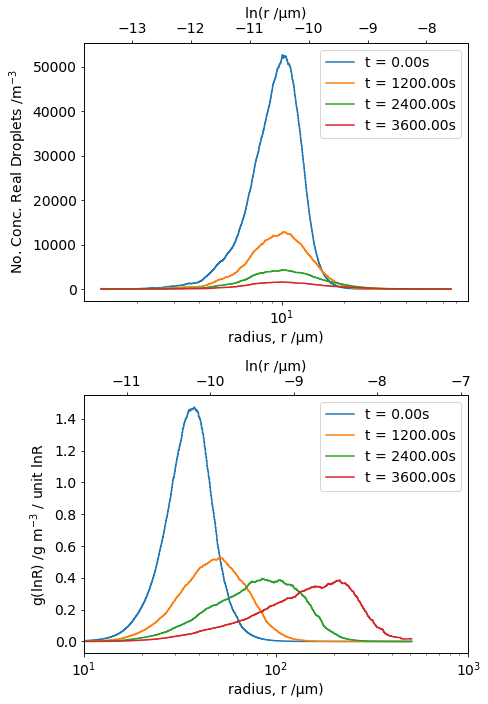

In [19]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
nbins = 1000
#rspan = [np.amin(r), np.amax(r)]
#rspan = [0.62e-6, 6.34e-2]
nplts = 4
#tplt = np.linspace(t[0], t[-1], nplts)
tplt = [0, 1200, 2400, 3600]
smoothsig = 0.62*nsupers**(-1/5)
#smoothsig = False


linear_twinax(ax1, np.log(r[0,:]), eps[0,:]/VOL)
wghts0 = eps[0,:]/VOL*SDprops.m(r[0,:], 0)*1000
#wghts0 = eps[0,:]/VOL*SDprops.m_w(r[0,:], m_sol[0,:])*1000
ax2b = linear_twinax(ax2, np.log(r[0,:]), wghts0)
for i in range(nplts):
        ind = np.argmin(abs(t-tplt[i]))
        tlab = 't = {:.2f}s'.format(t[ind])
        c = 'C'+str(i)
        logr_distribution(rspan, nbins, r[ind,:], eps[ind,:]/VOL, ax=ax1, 
                step=True, lab=tlab, c=c, ylab="No. Conc. Real Droplets /m$^{-3}$",
                perlnR=False, smooth=smoothsig)

        wghts = eps[ind,:]/VOL*SDprops.m(r[ind,:], 0)*1000
        #wghts = eps[ind,:]/VOL*SDprops.m_w(r[ind,:], m_sol[ind,:])*1000
        logr_distribution(rspan, nbins, r[ind,:], wghts, ax=ax2, 
                step=True, lab=tlab, c=c, 
                ylab="g(lnR) /g m$^{-3}$ / unit lnR",
                perlnR=True, smooth=smoothsig)
#ax1.set_yscale('log')
#ax2.set_yscale('log')
#ax2.set_ylim([0,1.8])
ax2.set_xlim([np.log(10e-6),np.log(1000e-6)])
ax2b.set_xlim([10,1000])

plt.tight_layout()

